In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install torchinfo
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 196 (delta 90), reused 182 (delta 83), pack-reused 0
Receiving objects: 100% (196/196), 64.83 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (90/90), done.


---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.models.ts_transformer import RelativeGlobalAttention
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1
from torchinfo import summary

<ipython-input-4-87cb1c02885a>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    
    "sem-space": 'attr',
    # model training configs
    "model_params":{
        "linear_filters":[512,1024,1024,256],
        "input_feat":36,
        "dropout":0.1,
    },
    "include_attribute_loss": True, 
    "n_actions": 18,
    "folding": True,
    "lr": 0.0001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
video_feat.shape

(18, 400)

In [ ]:
vid_cls_name = np.unique(video_classes)

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        self.lstm = nn.LSTM(input_size=self.d_model,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=False)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)
        self.DenseL3 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.Act(out)
        # out = self.AvgPoolL(out)
        # out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)   
        # out = self.DenseL3(out)
        # out = self.logist(out1)     
        return out

In [ ]:
# test model 
sample_input = torch.randn((32, 120, 42))
model = IMUEncoder(in_ft=42, d_model=128, num_heads=2, ft_size=128, n_classes=2, max_len=120, dropout=0.1)
sample_output = model(sample_input)
sample_output.shape

torch.Size([32, 128])

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [ ]:
selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

torch.Size([18, 400])

In [ ]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [ ]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((16752, 105, 27), (4189, 105, 27), (5608, 105, 27))

In [ ]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

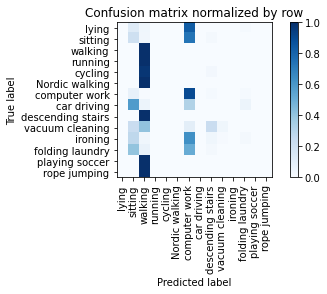

Overall accuracy: 0.287



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

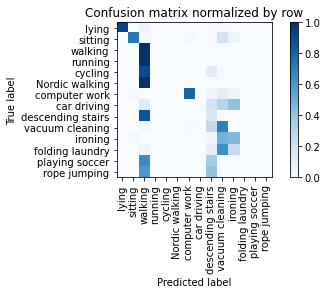

Overall accuracy: 0.507



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

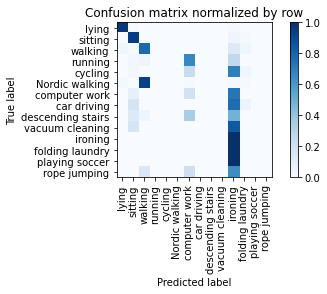

Overall accuracy: 0.410



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

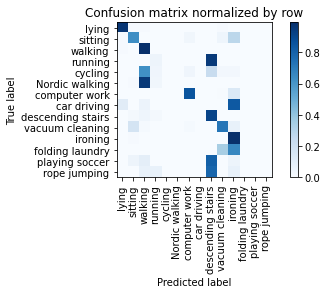

Overall accuracy: 0.612



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

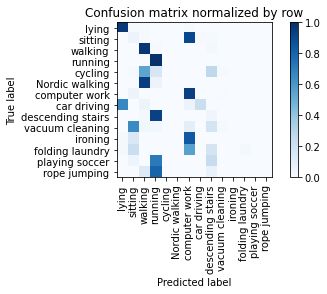

Overall accuracy: 0.407



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

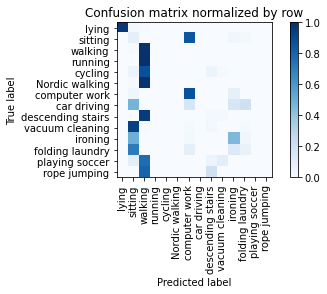

Overall accuracy: 0.410



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

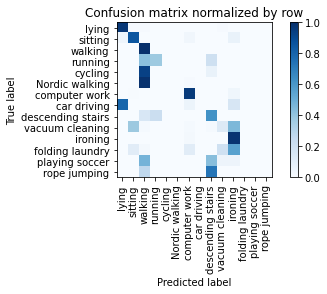

Overall accuracy: 0.602



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

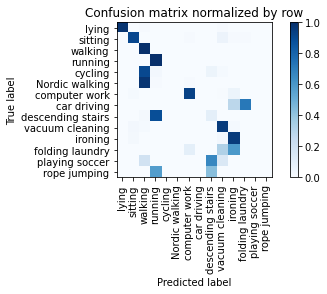

Overall accuracy: 0.666



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

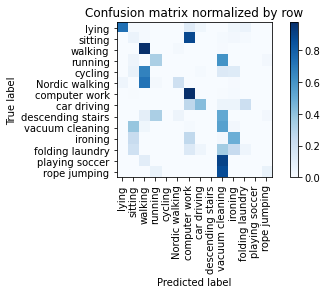

Overall accuracy: 0.482



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

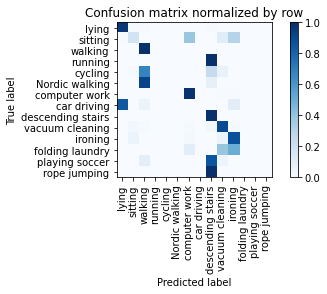

Overall accuracy: 0.595



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

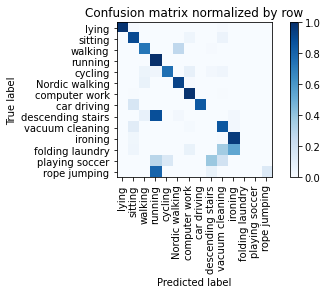

Overall accuracy: 0.784



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

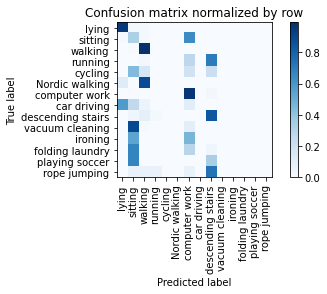

Overall accuracy: 0.425



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

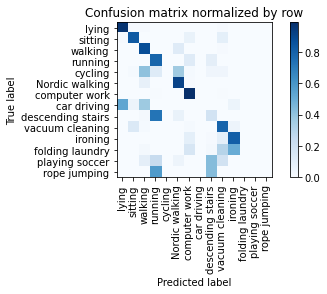

Overall accuracy: 0.699



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

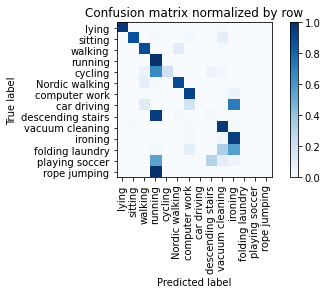

Overall accuracy: 0.741



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

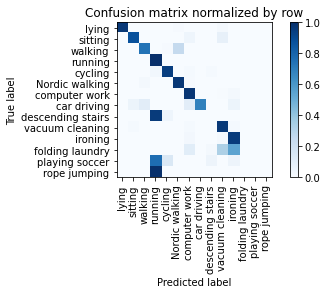

Overall accuracy: 0.802



unseen:   0%|          | 0/84 [00:00<?, ?batch/s]

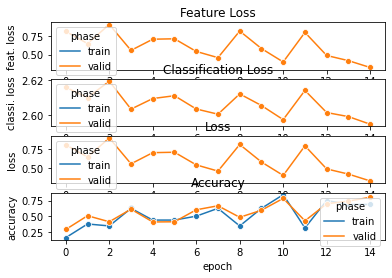

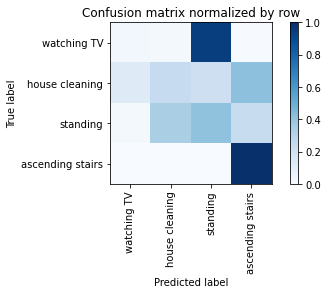

Overall accuracy: 0.402

{'accuracy': 0.4017857142857143, 'precision': 0.332158863713717, 'recall': 0.4203330756425193, 'f1': 0.34122100140557166, 'samples': 2688, 'loss': 3775.618366241455, 'feat. loss': 3775.2506141662598, 'classi. loss': 3677.6172676086426}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
seen classes >  [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
unseen classes >  [3, 17, 1, 11]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

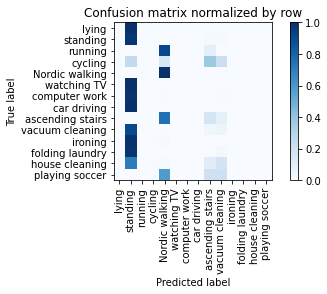

Overall accuracy: 0.172



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

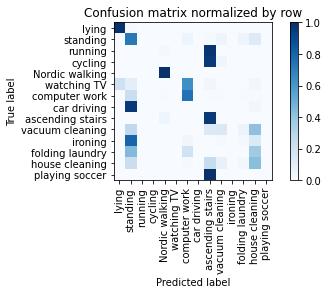

Overall accuracy: 0.449



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

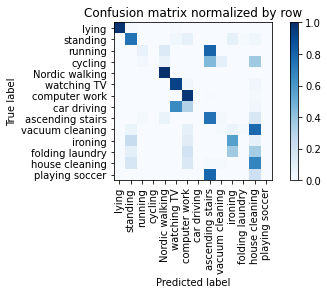

Overall accuracy: 0.579



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

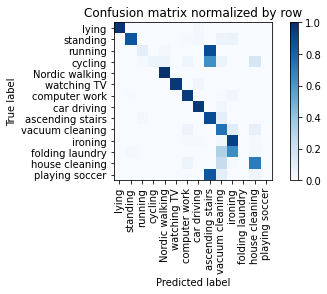

Overall accuracy: 0.731



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

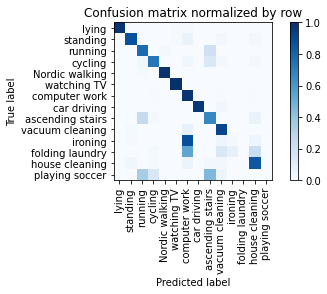

Overall accuracy: 0.734



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

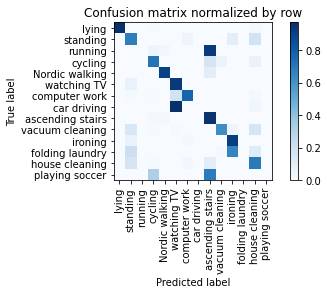

Overall accuracy: 0.690



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

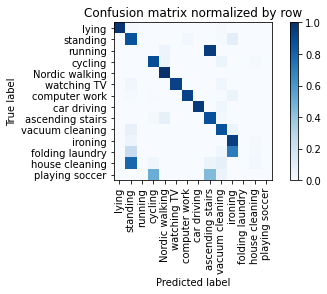

Overall accuracy: 0.745



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

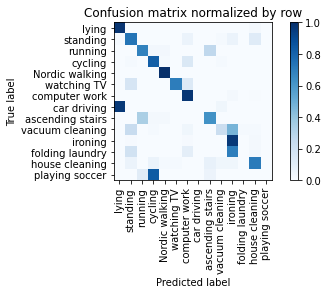

Overall accuracy: 0.724



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

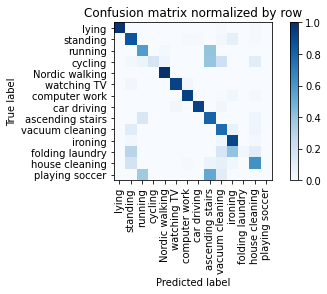

Overall accuracy: 0.747



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

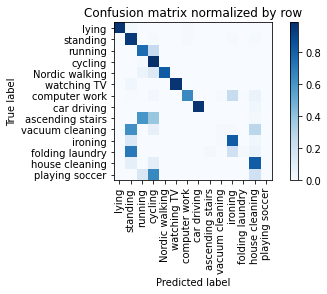

Overall accuracy: 0.665



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

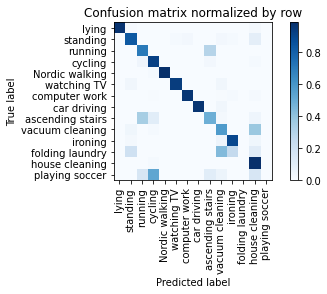

Overall accuracy: 0.806



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

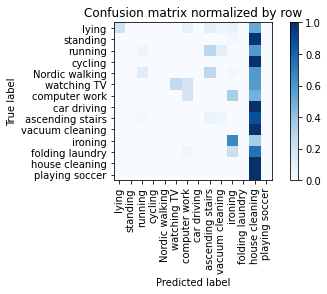

Overall accuracy: 0.213



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

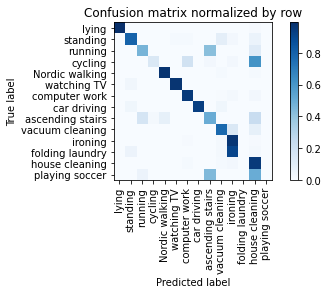

Overall accuracy: 0.757



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

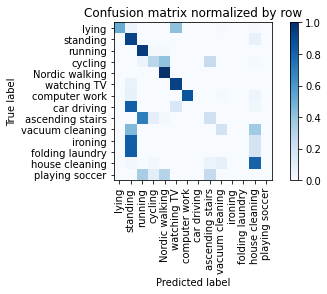

Overall accuracy: 0.531



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

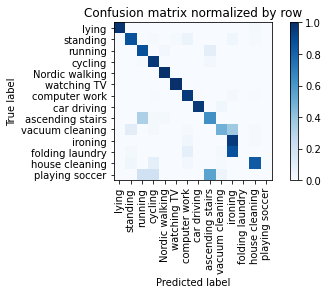

Overall accuracy: 0.816



unseen:   0%|          | 0/82 [00:00<?, ?batch/s]

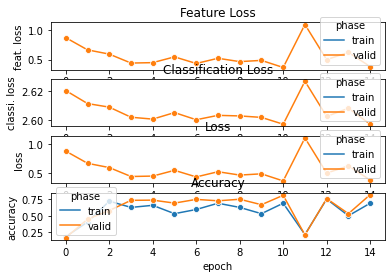

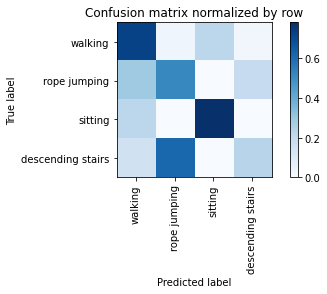

Overall accuracy: 0.648

{'accuracy': 0.6482469512195121, 'precision': 0.5765096226959023, 'recall': 0.562760739883988, 'f1': 0.5412451744817915, 'samples': 2624, 'loss': 2929.6906299591064, 'feat. loss': 2929.3421421051025, 'classi. loss': 3484.8288764953613}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
seen classes >  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17]
unseen classes >  [16, 0, 12, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

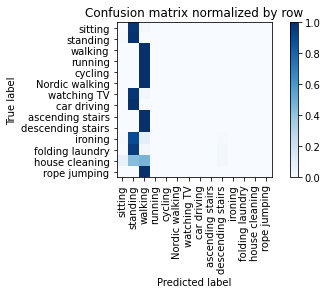

Overall accuracy: 0.220



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

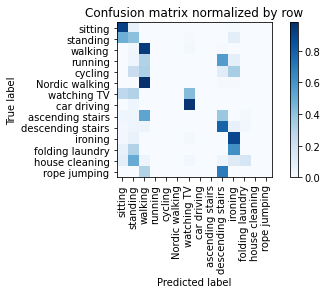

Overall accuracy: 0.404



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

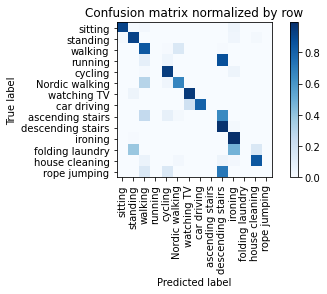

Overall accuracy: 0.735



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

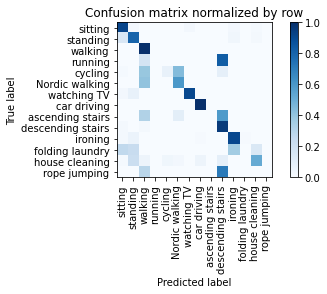

Overall accuracy: 0.624



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

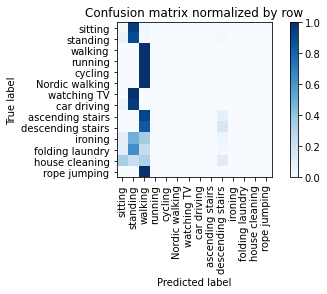

Overall accuracy: 0.219



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

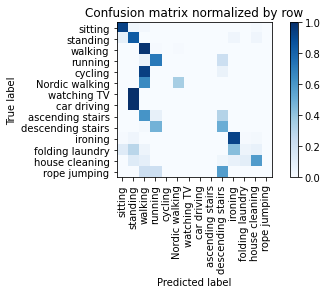

Overall accuracy: 0.552



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

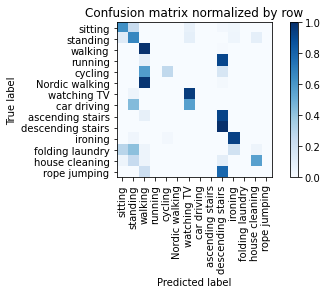

Overall accuracy: 0.524



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

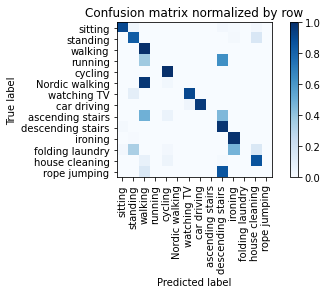

Overall accuracy: 0.685



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

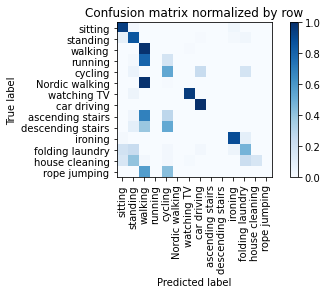

Overall accuracy: 0.552



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

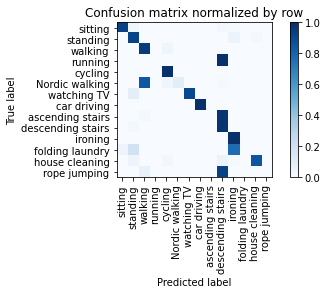

Overall accuracy: 0.703



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

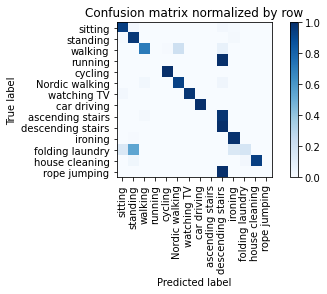

Overall accuracy: 0.786



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

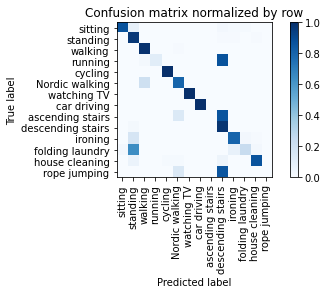

Overall accuracy: 0.776



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

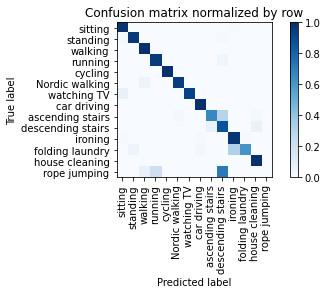

Overall accuracy: 0.925



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

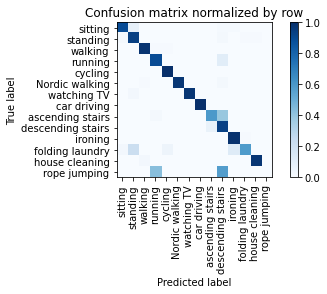

Overall accuracy: 0.911



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

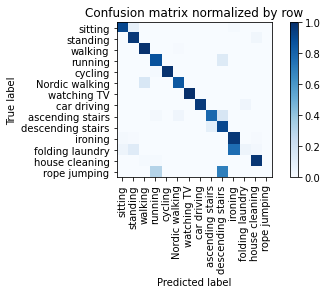

Overall accuracy: 0.883



unseen:   0%|          | 0/108 [00:00<?, ?batch/s]

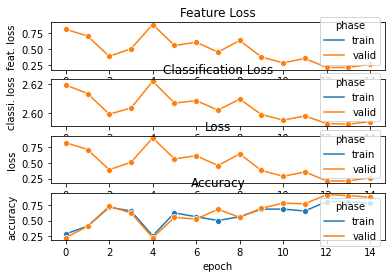

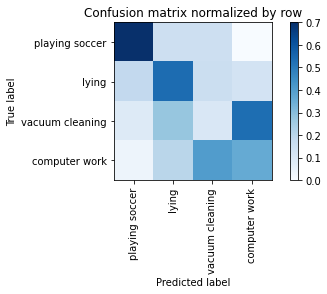

Overall accuracy: 0.369

{'accuracy': 0.36863425925925924, 'precision': 0.3527594114721229, 'recall': 0.4260262929555459, 'f1': 0.37113590575647715, 'samples': 3456, 'loss': 4408.558193206787, 'feat. loss': 4408.086803436279, 'classi. loss': 4713.71427154541}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
seen classes >  [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
unseen classes >  [5, 4, 6]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

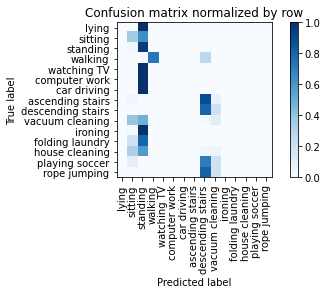

Overall accuracy: 0.220



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

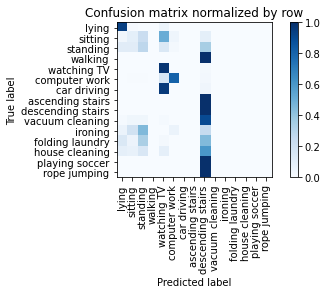

Overall accuracy: 0.318



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

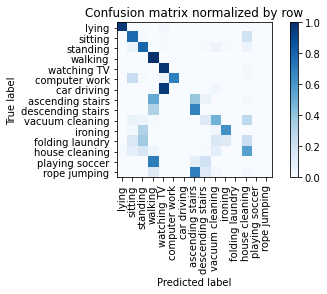

Overall accuracy: 0.621



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

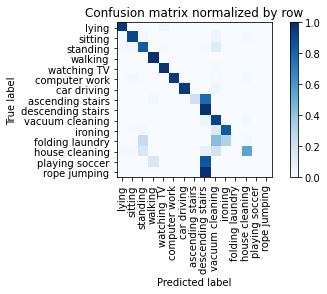

Overall accuracy: 0.777



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

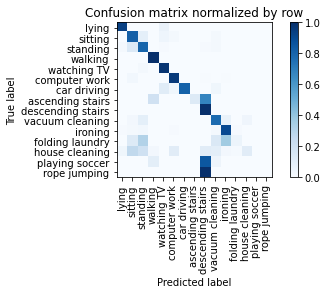

Overall accuracy: 0.721



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

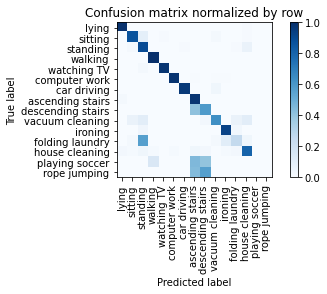

Overall accuracy: 0.823



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

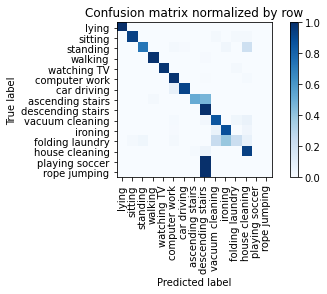

Overall accuracy: 0.828



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

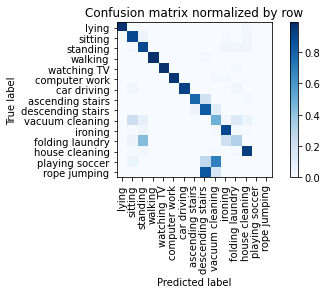

Overall accuracy: 0.822



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

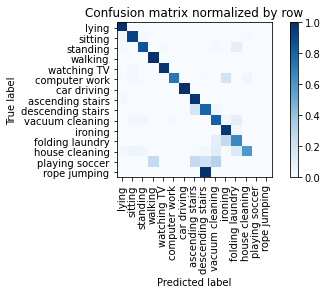

Overall accuracy: 0.816



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

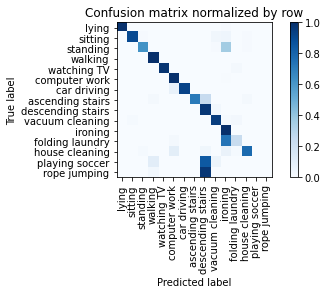

Overall accuracy: 0.832



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

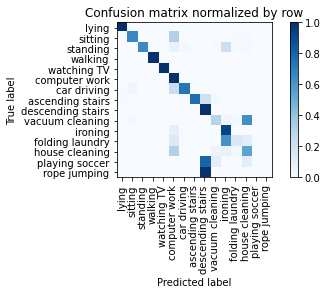

Overall accuracy: 0.739



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

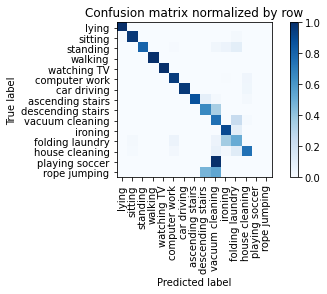

Overall accuracy: 0.834



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

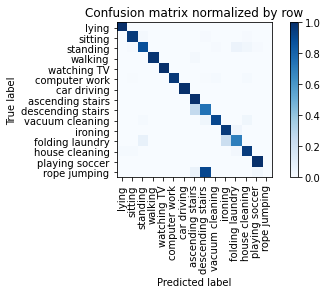

Overall accuracy: 0.910



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

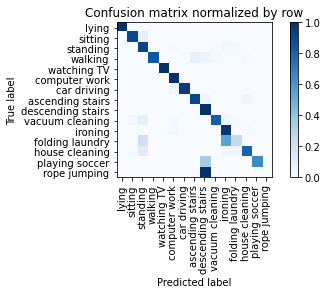

Overall accuracy: 0.860



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

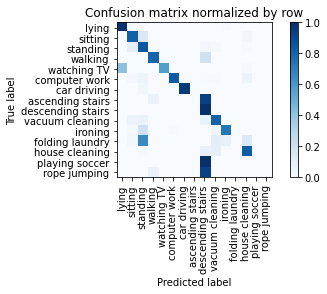

Overall accuracy: 0.713



unseen:   0%|          | 0/66 [00:00<?, ?batch/s]

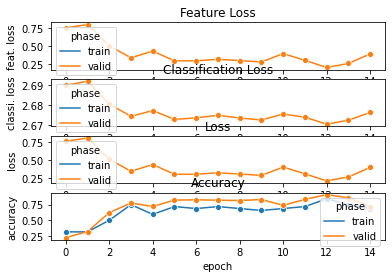

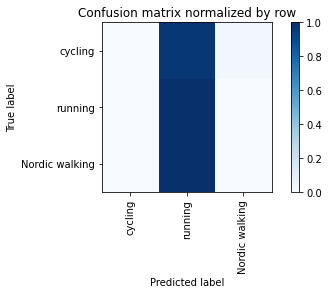

Overall accuracy: 0.214

{'accuracy': 0.21401515151515152, 'precision': 0.07215836526181353, 'recall': 0.3333333333333333, 'f1': 0.11863517060367453, 'samples': 2112, 'loss': 2878.5740127563477, 'feat. loss': 2878.3403396606445, 'classi. loss': 2336.8238792419434}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

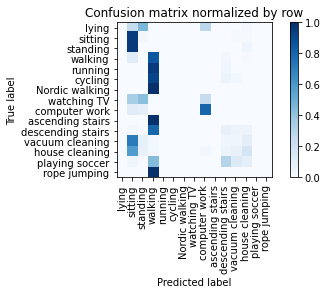

Overall accuracy: 0.295



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

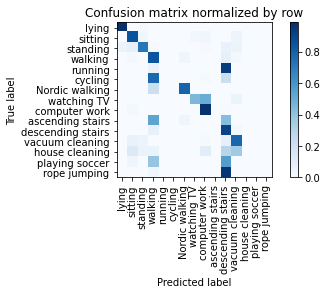

Overall accuracy: 0.598



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

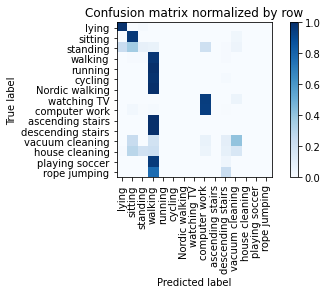

Overall accuracy: 0.410



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

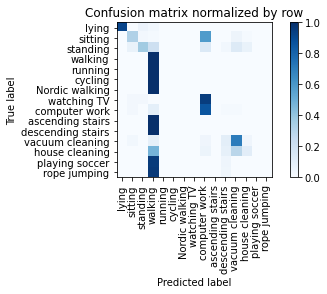

Overall accuracy: 0.403



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

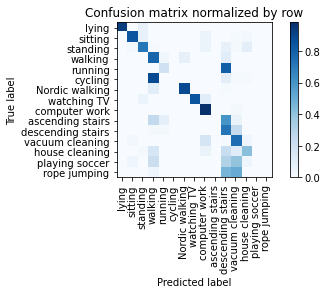

Overall accuracy: 0.643



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

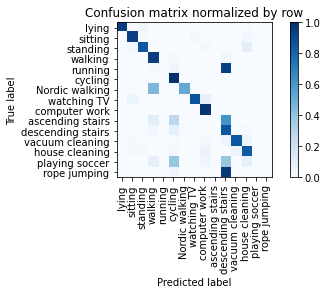

Overall accuracy: 0.767



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

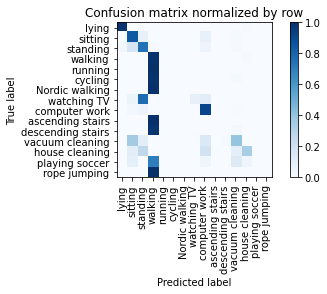

Overall accuracy: 0.492



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

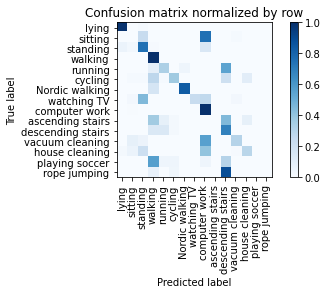

Overall accuracy: 0.574



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

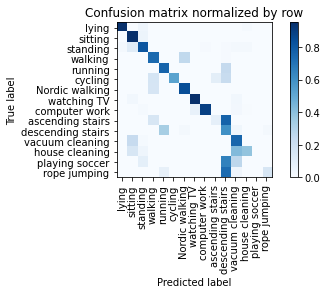

Overall accuracy: 0.702



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

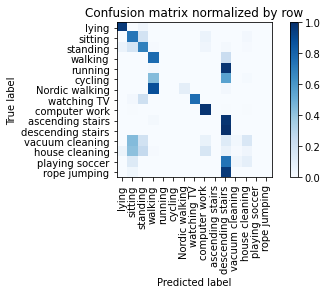

Overall accuracy: 0.495



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

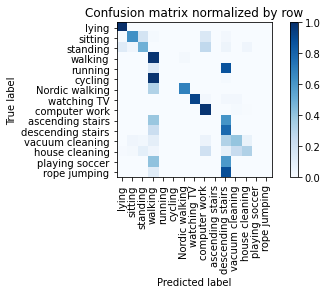

Overall accuracy: 0.583



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

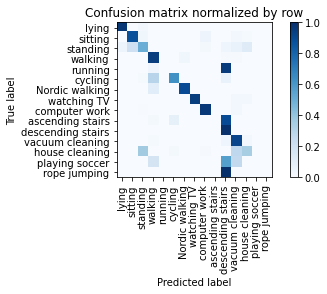

Overall accuracy: 0.701



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

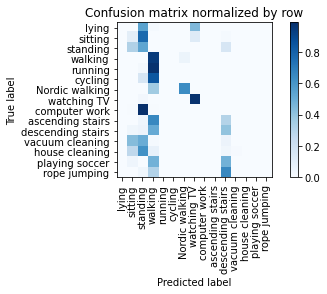

Overall accuracy: 0.257



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

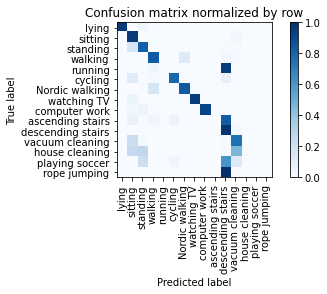

Overall accuracy: 0.687



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

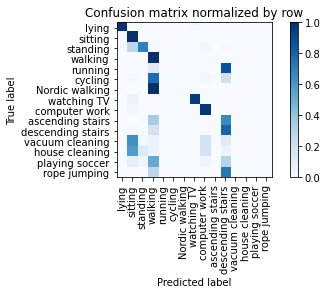

Overall accuracy: 0.524



unseen:   0%|          | 0/58 [00:00<?, ?batch/s]

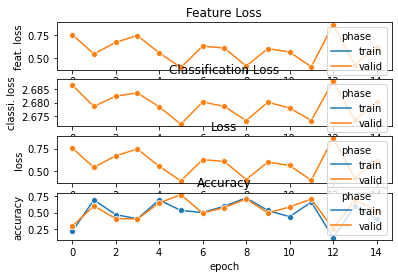

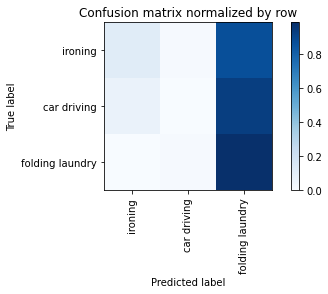

Overall accuracy: 0.320

{'accuracy': 0.32004310344827586, 'precision': 0.40364993916179576, 'recall': 0.3695580254135387, 'f1': 0.21353191125576532, 'samples': 1856, 'loss': 2061.554334640503, 'feat. loss': 2061.355016708374, 'classi. loss': 1993.0901641845703}
============== Overall Unseen Classes Performance ==============


accuracy           0.390545
precision          0.347447
recall             0.422402
f1                 0.317154
samples         2547.200000
loss            3210.799107
feat. loss      3210.474983
classi. loss    3241.214892
dtype: float64

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
